<a href="https://colab.research.google.com/github/Prabzmihi/DDODM/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task 1

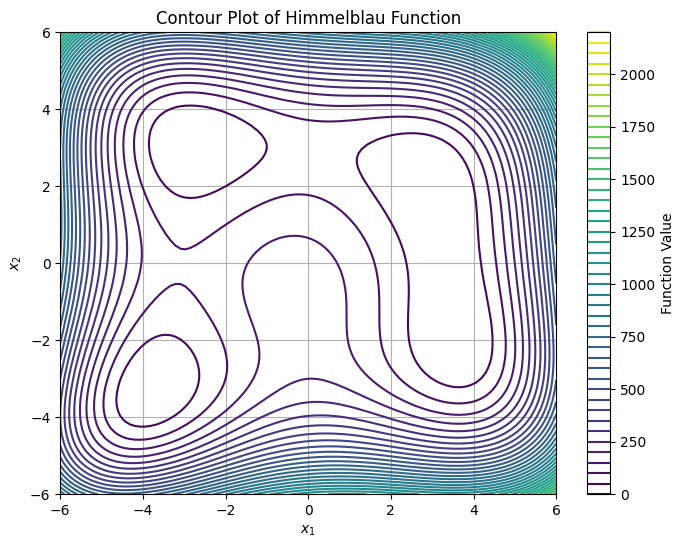

In [1]:
#Plotting the Himmelblau Function
import numpy as np
import matplotlib.pyplot as plt

# Define the Himmelblau function
def himmelblau(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

# Generate x and y values
x = np.linspace(-6, 6, 100)
y = np.linspace(-6, 6, 100)
X, Y = np.meshgrid(x, y)
Z = himmelblau(X, Y)

# Create contour plot
plt.figure(figsize=(8, 6))
contour = plt.contour(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(contour, label='Function Value')
plt.title('Contour Plot of Himmelblau Function')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.grid(True)
plt.show()

In [2]:
#Kriging Prediction Implementation
import numpy as np
import matplotlib.pyplot as plt

# Define the Himmelblau function
def himmelblau(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

# Exponential covariance function adjusted for 2D input
def exponential_cov(x, y, params):
    sq_diff = np.sum((x[:, np.newaxis, :] - y[np.newaxis, :, :])**2, axis=2)
    return params[0] * np.exp(-0.7 * params[1] * sq_diff)

# Prediction function for kriging
def predict(x, data, kernel, params, sigma, t):
    k = np.array([kernel(np.array([x]), np.array([y]), params) for y in data]).squeeze()
    Sinv = np.linalg.inv(sigma)
    y_pred = k.dot(Sinv).dot(t)
    k = k.reshape(-1, 1)
    sigma_new = kernel(np.array([x]), np.array([x]), params).squeeze() - k.T.dot(Sinv).dot(k)
    return y_pred, sigma_new

# Number of samples and their generation
num_samples = 88
x_samples = np.random.uniform(-5, 5, (num_samples, 2))
y_samples = np.array([himmelblau(x[0], x[1]) for x in x_samples])

# Parameters for the covariance function
params = [1.0, 0.1]
sigma = exponential_cov(x_samples, x_samples, params)

Iteration 1: Point [3.13289161 1.74382964], Predicted Value: -22.271362927554357, Actual Value: 0.9948527821629587, Error: 23.266215709717315, Std Dev: [[0.0526414]]
Iteration 2: Point [ 3.32563612 -4.45332098], Predicted Value: -79.82692571113184, Actual Value: 280.3739326628058, Error: 360.20085837393765, Std Dev: [[0.88253914]]
Iteration 3: Point [-4.67314405 -4.45763947], Predicted Value: 16.507748941308737, Actual Value: 107.90997175914669, Error: 91.40222281783795, Std Dev: [[0.99661629]]
Iteration 4: Point [3.3351829  1.87482102], Predicted Value: 8.359692019419784, Actual Value: 4.015526110364557, Error: 4.344165909055227, Std Dev: [[0.00745198]]
Iteration 5: Point [2.46917735 2.15744242], Predicted Value: 11.422684333517534, Actual Value: 7.554293020325774, Error: 3.8683913131917596, Std Dev: [[0.01883463]]
Iteration 6: Point [ 3.16513014 -1.41578203], Predicted Value: 4.221402643210439, Actual Value: 9.099602505640217, Error: 4.878199862429778, Std Dev: [[0.10986436]]
Iterati

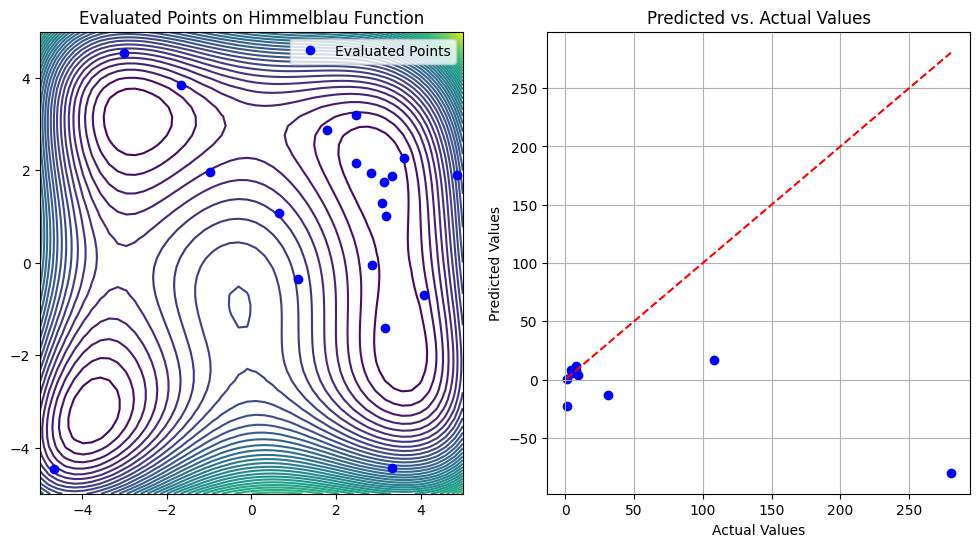

In [10]:
#Bayesian Optimization Loop
# Define the acquisition function (Lower Confidence Bound)
def acquisition_lcb(y_pred, sigma_new, w):
    return y_pred - w * np.sqrt(sigma_new)

# Bayesian optimization loop
K = 10  # Initial number of points
theta = 0.1
w = 2.0  # LCB weight parameter

# Initial random samples
initial_points = np.random.uniform(-5, 5, (K, 2))
initial_values = np.array([himmelblau(x[0], x[1]) for x in initial_points])

# Perform the optimization for 10 iterations
iterations = 10
new_points = initial_points.tolist()
predicted_values = initial_values.tolist()
prediction_errors = []

for i in range(iterations):
    # Update the covariance matrix with current data
    sigma = exponential_cov(np.array(new_points), np.array(new_points), params)

    # Generate candidate points for evaluation
    candidate_points = np.random.uniform(-5, 5, (num_samples, 2))
    candidate_acquisitions = []

    for point in candidate_points:
        y_pred, sigma_new = predict(point, np.array(new_points), exponential_cov, params, sigma, np.array(predicted_values))
        lcb = acquisition_lcb(y_pred, sigma_new, w)
        candidate_acquisitions.append((point, lcb, y_pred, sigma_new))

    # Select the candidate with the lowest acquisition function value
    best_candidate = min(candidate_acquisitions, key=lambda x: x[1])
    best_point, best_lcb, best_y_pred, best_sigma_new = best_candidate

    # Evaluate the true function value
    actual_value = himmelblau(best_point[0], best_point[1])
    prediction_error = np.abs(best_y_pred - actual_value)

    # Update the lists
    new_points.append(best_point)
    predicted_values.append(actual_value)
    prediction_errors.append((best_point, best_y_pred, actual_value, prediction_error, best_sigma_new))

    print(f"Iteration {i+1}: Point {best_point}, Predicted Value: {best_y_pred}, Actual Value: {actual_value}, Error: {prediction_error}, Std Dev: {np.sqrt(best_sigma_new)}")

# Plot the results
X, Y = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = himmelblau(X, Y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.contour(X, Y, Z, levels=50, cmap='viridis')
new_points_np = np.array(new_points)
ax1.plot(new_points_np[:, 0], new_points_np[:, 1], 'bo', label='Evaluated Points')
ax1.legend()
ax1.set_title('Evaluated Points on Himmelblau Function')

actual_vals = [item[2] for item in prediction_errors]
pred_vals = [item[1] for item in prediction_errors]
ax2.scatter(actual_vals, pred_vals, color='blue')
ax2.plot([min(actual_vals), max(actual_vals)], [min(actual_vals), max(actual_vals)], 'r--')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title('Predicted vs. Actual Values')
ax2.grid(True)
plt.show()

#Task 2 (Bonus)

In [31]:
#Maximum Likelihood Estimation for Hyperparameter Tuning
from scipy.optimize import minimize

def log_likelihood(params, x_samples, y_samples, kernel):
    sigma = kernel(x_samples, x_samples, params)
    sigma += 1e-10 * np.eye(sigma.shape[0])

    L = np.linalg.cholesky(sigma)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_samples))
    log_det_sigma = 2 * np.sum(np.log(np.diag(L)))

    ll = -0.5 * y_samples.dot(alpha) - 0.5 * log_det_sigma - 0.5 * len(y_samples) * np.log(2 * np.pi)
    return -ll

# Optimize hyperparameters using MLE
initial_params = [1.0, 0.1]
result = minimize(log_likelihood, initial_params, args=(x_samples, y_samples, exponential_cov), bounds=((1e-5, None), (1e-5, None)))
optimal_params = result.x
print(f"Optimal parameters found by MLE: {optimal_params}")

Optimal parameters found by MLE: [986.60633432   2.04803464]


Iteration 1: Point [-4.67067594 -1.69899436], Predicted Value: 1.4735051420268015, Actual Value: 160.2657646561824, Error: 158.7922595141556, Std Dev: [[31.34874334]]
Iteration 2: Point [-4.78808677 -3.8453375 ], Predicted Value: 2.655975171855399, Actual Value: 74.28467362511952, Error: 71.62869845326412, Std Dev: [[31.37394208]]
Iteration 3: Point [-4.80021446 -0.06136221], Predicted Value: 11.751116459451419, Actual Value: 282.69330356134293, Error: 270.94218710189153, Std Dev: [[31.33170884]]
Iteration 4: Point [-3.16922138  3.04028585], Predicted Value: -0.02683721793858665, Actual Value: 5.201358050863092, Error: 5.228195268801679, Std Dev: [[23.35340391]]
Iteration 5: Point [-3.3120913  -3.22567165], Predicted Value: 1.4097076850056736, Actual Value: 10.608355521930227, Error: 9.198647836924554, Std Dev: [[25.44729683]]
Iteration 6: Point [ 4.65605809 -1.46570012], Predicted Value: 8.852208203189544, Actual Value: 84.92091136356177, Error: 76.06870316037222, Std Dev: [[24.985196

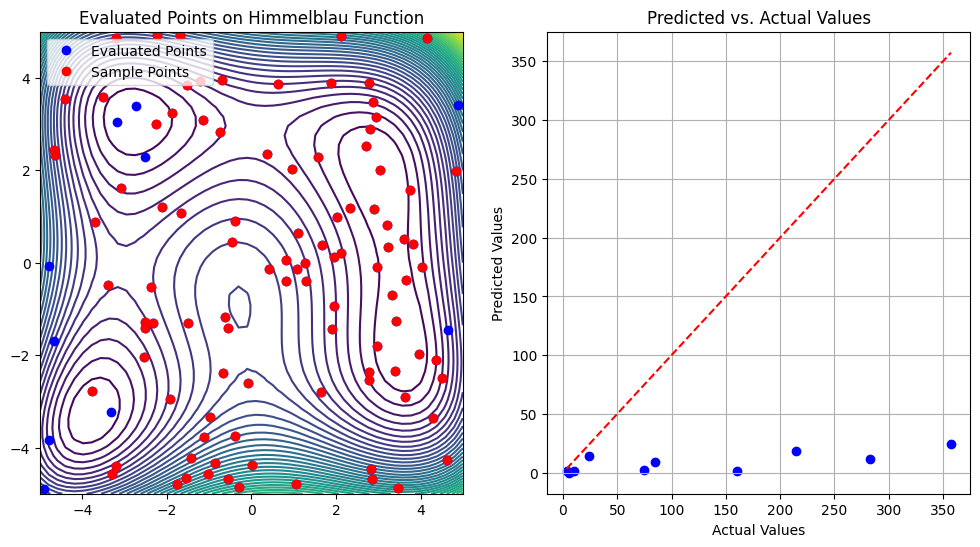

In [33]:
# Re-run Bayesian Optimization with Tuned Hyperparameters

# Prediction function for kriging
def predict(x, data, kernel, params, sigma, t):
    k = np.array([kernel(np.array([x]), np.array([y]), params) for y in data]).squeeze()
    Sinv = np.linalg.inv(sigma)
    y_pred = k.dot(Sinv).dot(t)
    k = k.reshape(-1, 1)
    sigma_new = kernel(np.array([x]), np.array([x]), params).squeeze() - k.T.dot(Sinv).dot(k)
    return y_pred, sigma_new

# Define the acquisition function (Lower Confidence Bound)
def acquisition_lcb(y_pred, sigma_new, w):
    return y_pred - w * np.sqrt(sigma_new)

# Bayesian optimization loop with tuned parameters
K = 100  # Initial number of points
theta = optimal_params[1]
w = 2.0  # LCB weight parameter

# Initial random samples
initial_points = np.random.uniform(-5, 5, (K, 2))
initial_values = np.array([himmelblau(x[0], x[1]) for x in initial_points])

# Perform the optimization for 10 iterations
iterations = 10
new_points = initial_points.tolist()
predicted_values = initial_values.tolist()
prediction_errors = []

for i in range(iterations):
    # Update the covariance matrix with current data
    sigma = exponential_cov(np.array(new_points), np.array(new_points), optimal_params)

    # Generate candidate points for evaluation
    candidate_points = np.random.uniform(-5, 5, (num_samples, 2))
    candidate_acquisitions = []

    for point in candidate_points:
        y_pred, sigma_new = predict(point, np.array(new_points), exponential_cov, optimal_params, sigma, np.array(predicted_values))
        lcb = acquisition_lcb(y_pred, sigma_new, w)
        candidate_acquisitions.append((point, lcb, y_pred, sigma_new))

    # Select the candidate with the lowest acquisition function value
    best_candidate = min(candidate_acquisitions, key=lambda x: x[1])
    best_point, best_lcb, best_y_pred, best_sigma_new = best_candidate

    # Evaluate the true function value
    actual_value = himmelblau(best_point[0], best_point[1])
    prediction_error = np.abs(best_y_pred - actual_value)

    # Update the lists
    new_points.append(best_point)
    predicted_values.append(actual_value)
    prediction_errors.append((best_point, best_y_pred, actual_value, prediction_error, best_sigma_new))

    print(f"Iteration {i+1}: Point {best_point}, Predicted Value: {best_y_pred}, Actual Value: {actual_value}, Error: {prediction_error}, Std Dev: {np.sqrt(best_sigma_new)}")

# Plot the results
X, Y = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = himmelblau(X, Y)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.contour(X, Y, Z, levels=50, cmap='viridis')
new_points_np = np.array(new_points)
sample_points_np = np.array(initial_points)
ax1.plot(new_points_np[:, 0], new_points_np[:, 1], 'bo', label='Evaluated Points')
ax1.plot(sample_points_np[:, 0], sample_points_np[:, 1], 'ro', label='Sample Points')
ax1.legend()
ax1.set_title('Evaluated Points on Himmelblau Function')

actual_vals = [item[2] for item in prediction_errors]
pred_vals = [item[1] for item in prediction_errors]
ax2.scatter(actual_vals, pred_vals, color='blue')
ax2.plot([min(actual_vals), max(actual_vals)], [min(actual_vals), max(actual_vals)], 'r--')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title('Predicted vs. Actual Values')
ax2.grid(True)
plt.show()